# Analysis of the Bcl-Xl clusters

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

## File parsing

In [2]:
cluster_file = "../results/clusters.txt"
info_file = "../results/dataset_composition.csv"
pdb_fold = "../results/PDB/"

In [ ]:
info = pd.read_csv(info_file, sep=";")
info = info.drop_duplicates(ignore_index=True)
info.head()


,pdb_id,experimental method,resolution,number of models,nbr of chain,chain:length,HETATM:Occ,chn:UniProtId:pos
0,3ZK6,X-RAY DIFFRACTION,2.48,NaN,2,A:144/B:144,H1I:2,A:Q07817:1-40
1,1R2E,X-RAY DIFFRACTION,2.10,NaN,1,A:143,NaN,A:Q07817:1-211
2,3CVA,X-RAY DIFFRACTION,2.70,NaN,1,X:141,NaN,X:Q07817:1-211
3,1MAZ,X-RAY DIFFRACTION,2.20,NaN,1,A:143,NaN,A:Q07817:1-209
4,1R2G,X-RAY DIFFRACTION,2.70,NaN,1,A:143,NaN,A:Q07817:1-211


In [4]:
clusters = {}
with open(cluster_file, "r") as f:
    for line in f:
        if line.startswith("Cluster"):
            cluster = int(line.split(" ")[1][:-1])
            refs = line.split(" ")[2:]
            ids = [id[:6].strip() for id in refs]
            clusters[cluster] = ids
print(clusters)

{1: ['3QKD_A', '2YXJ_B', '3QKD_B', '3PL7_A', '3FDM_C'], 2: ['3SP7_A', '3SPF_A', '4EHR_A'], 3: ['4QVF_A', '2P1L_E'], 4: ['3ZK6_A', '3ZK6_B'], 5: ['4BPK_B', '4BPK_A', '2YJ1_C', '5B1Z_A', '5B1Z_B'], 6: ['6HJL_B', '6HJL_F', '6HJL_E'], 7: ['6UVG_I', '6UVF_E', '6UVF_G', '6UVF_L', '6UVG_D', '6UVG_J'], 8: ['6UVF_J', '6UVG_L', '6UVF_A', '6UVF_B', '6UVF_D', '6UVG_B', '6UVF_I', '6UVF_C', '6UVF_H', '6UVG_G', '6UVG_A', '6UVD_A', '6UVF_F', '6UVG_E', '6UVC_B', '6UVG_K', '6UVG_H', '6UVG_F', '6UVC_A', '6UVG_C'], 9: ['3FDL_A', '2YQ6_A', '2YQ7_A'], 10: ['4C52_A', '4C5D_A'], 11: ['4TUH_B', '4TUH_A', '3ZLR_A', '4TUH_G', '4TUH_E', '4TUH_H', '4TUH_C', '4TUH_F', '4TUH_D', '3ZLR_B'], 12: ['7JGW_A', '6UVD_B', '7JGV_A', '7JGV_B', '6ST2_B'], 13: ['4A1W_C', '5VX3_C', '5VX3_A', '4A1W_A'], 14: ['3INQ_A', '3INQ_B'], 15: ['5C3G_A'], 16: ['3FDM_B', '4A1W_D', '3FDM_A', '4A1W_B'], 17: ['5VX3_G', '5VX3_E'], 18: ['3IO8_C'], 19: ['6UVH_A', '6UVH_B', '6UVH_D', '6UVH_C'], 20: ['6DCN_B', '6DCN_A', '6DCO_A', '6DCO_B'], 21: ['2Y

## Cluster analysis

### Cluster description

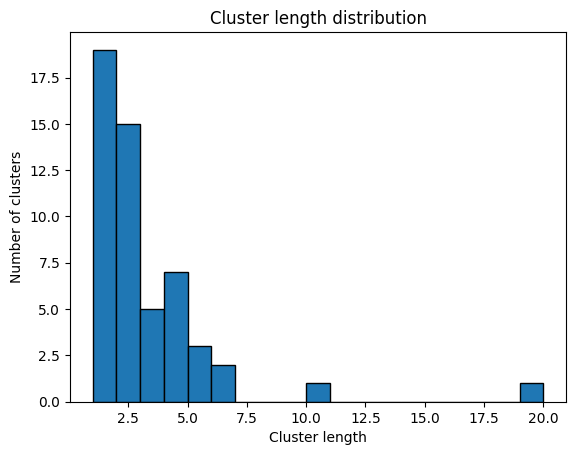

In [5]:
cluster_length = [len(ids) for cluster, ids in clusters.items()]
plt.hist(cluster_length, 
         bins=range(1, max(cluster_length)+1), 
         edgecolor="black")
plt.xlabel("Cluster length")
plt.ylabel("Number of clusters")
plt.title("Cluster length distribution")
plt.show()

In [6]:
clusters_one_struct = len([l for l in cluster_length if l == 1])
print(f"There are {clusters_one_struct} clusters with only one structure")

There are 19 clusters with only one structure


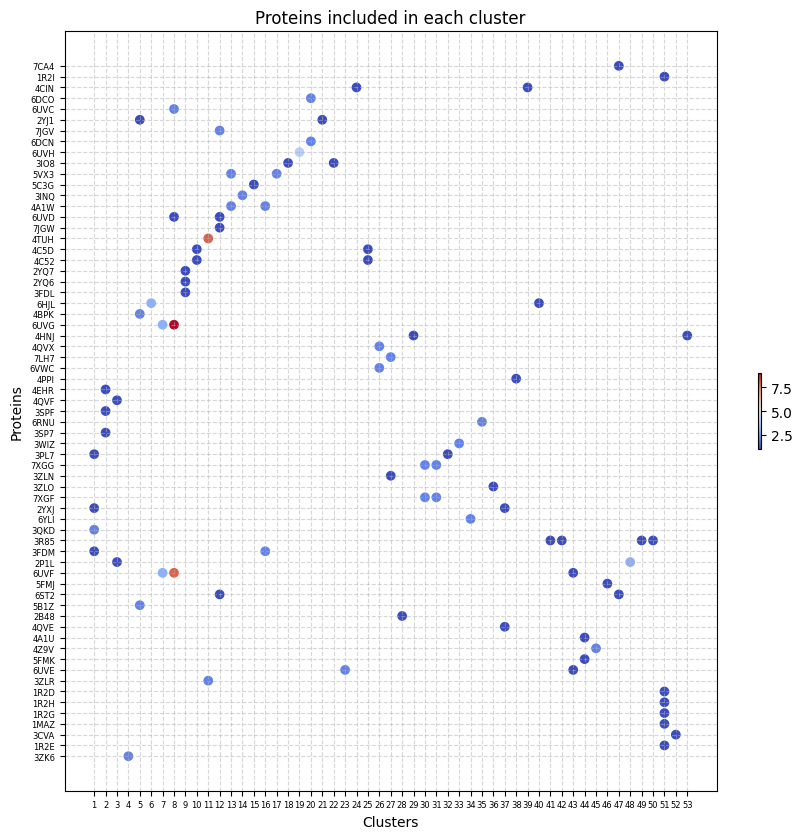

In [ ]:
proteins = list(info["pdb_id"])
cluster_ids = list(clusters.keys())
y_labels = {protein: i for i, protein in enumerate(proteins)}

x_coords = []
y_coords = []
colors = []

for cluster_id, chains in clusters.items():
    # Count the proteins occurrences for this cluster
    counts = Counter(chain.split("_")[0] for chain in chains)
    for protein, count in counts.items():
        if protein in y_labels:
            x_coords.append(cluster_id)
            y_coords.append(y_labels[protein])
            colors.append(count)
            
# Create dot plot
plt.figure(figsize=(9, 8.5))
scatter = plt.scatter(
    x_coords,
    y_coords,
    c=colors,
    cmap="coolwarm")
cbar = plt.colorbar(scatter, shrink=0.1)

# Labels
plt.yticks(range(len(proteins)), proteins, fontsize=6)
plt.xticks(cluster_ids, fontsize=6)
plt.xlabel("Clusters")
plt.ylabel("Proteins")
plt.title("Proteins included in each cluster")
plt.grid(axis="both", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Protein characteristics

#### Get characteristics from PDB files

In [8]:
info_pdb = {}

for prot in proteins:
    info_pdb[prot] = {}
    pdb_file = pdb_fold + prot + ".pdb"
    with open(pdb_file, "r") as f:
        for line in f:
            if line.startswith("REMARK 350"):
                if "TOTAL BURIED SURFACE AREA" in line:
                    txt = line.split()
                    number = float(txt[-2])
                    info_pdb[prot]["buried_area"] = number
                elif "SURFACE AREA OF THE COMPLEX" in line:
                    txt = line.split()
                    number = float(txt[-2])
                    info_pdb[prot]["complex_area"] = number
                elif "CHANGE IN SOLVENT FREE ENERGY" in line:
                    txt = line.split()
                    number = float(txt[-2])
                    info_pdb[prot]["energy"] = number
            elif line.startswith("REMARK 400   NAME:"):
                if "mol" not in info_pdb[prot]:
                    info_pdb[prot]["mol"] = []
                txt = line.split()
                mol_name = " ".join(txt[3:])
                info_pdb[prot]["mol"].append(mol_name)
                

In [9]:
for prot in proteins:
    if info_pdb[prot] != {}:
        print(f"{prot}: {info_pdb[prot]}")

3ZLR: {'buried_area': 4940.0, 'complex_area': 14560.0, 'energy': -68.6}
6UVE: {'buried_area': 4360.0, 'complex_area': 14320.0, 'energy': -29.0}
5FMK: {'buried_area': 9860.0, 'complex_area': 15040.0, 'energy': -58.1}
4Z9V: {'buried_area': 16280.0, 'complex_area': 17720.0, 'energy': -143.0}
4A1U: {'buried_area': 2550.0, 'complex_area': 10020.0, 'energy': -36.4}
4QVE: {'buried_area': 2340.0, 'complex_area': 8450.0, 'energy': -16.0}
2B48: {'buried_area': 7060.0, 'complex_area': 15130.0, 'energy': -74.0}
5B1Z: {'buried_area': 7670.0, 'complex_area': 16500.0, 'energy': -54.0}
6ST2: {'buried_area': 6690.0, 'complex_area': 24050.0, 'energy': -61.0}
5FMJ: {'buried_area': 9690.0, 'complex_area': 16760.0, 'energy': -37.3}
6UVF: {'buried_area': 4380.0, 'complex_area': 14260.0, 'energy': -43.0}
2P1L: {'buried_area': 8380.0, 'complex_area': 15080.0, 'energy': -52.0}
3FDM: {'buried_area': 8080.0, 'complex_area': 14410.0, 'energy': -48.0}
3R85: {'buried_area': 1830.0, 'complex_area': 9710.0, 'energy':

In [10]:
buried_area = {}
complex_area = {}
energy = {}
for cluster in clusters:
    for chain in clusters[cluster]:
        prot = chain.split("_")[0]
        if "buried_area" in info_pdb[prot]:
            nb = info_pdb[prot]["buried_area"]
            if cluster not in buried_area:
                buried_area[cluster] = []
            buried_area[cluster].append(nb)
        if "complex_area" in info_pdb[prot]:
            nb = info_pdb[prot]["complex_area"]
            if cluster not in complex_area:
                complex_area[cluster] = []
            complex_area[cluster].append(nb)
        if "energy" in info_pdb[prot]:
            nb = info_pdb[prot]["energy"]
            if cluster not in energy:
                energy[cluster] = []
            energy[cluster].append(nb)
            
max_buried = max([max(buried_area[cluster]) for cluster in buried_area])
min_buried = min([min(buried_area[cluster]) for cluster in buried_area])
max_complex = max([max(complex_area[cluster]) for cluster in complex_area])
min_complex = min([min(complex_area[cluster]) for cluster in complex_area])
max_energy = max([max(energy[cluster]) for cluster in energy])
min_energy = min([min(energy[cluster]) for cluster in energy])
            
for cluster in clusters:
    if cluster not in buried_area:
        buried_area[cluster] = [max_buried+1000000]
    if cluster not in complex_area:
        complex_area[cluster] = [max_complex+1000000]
    if cluster not in energy:
        energy[cluster] = [max_energy+1000000]

#### Plot distributions

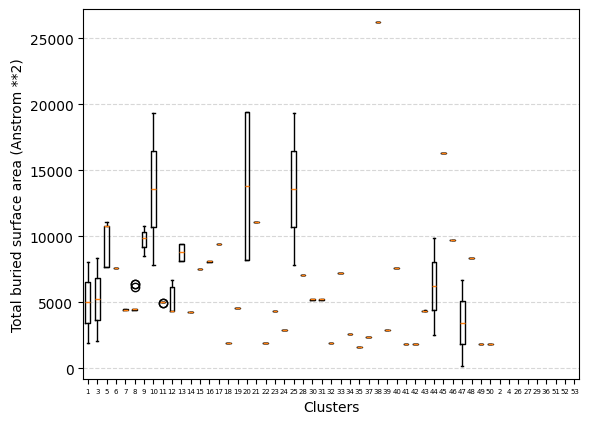

In [11]:
plt.boxplot(buried_area.values())
plt.ylim(min_buried-1000, max_buried+1000)
plt.xticks(range(1, len(buried_area)+1), buried_area.keys(), fontsize=5)
plt.xlabel("Clusters")
plt.ylabel("Total buried surface area (Anstrom **2)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

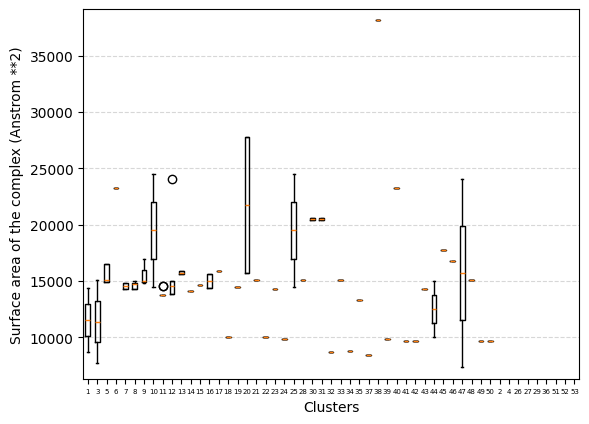

In [12]:
plt.boxplot(complex_area.values())
plt.ylim(min_complex-1000, max_complex+1000)
plt.xticks(range(1, len(complex_area)+1), complex_area.keys(), fontsize=5)
plt.xlabel("Clusters")
plt.ylabel("Surface area of the complex (Anstrom **2)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

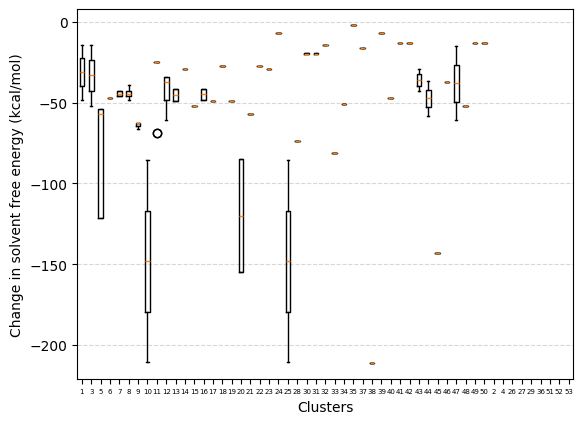

In [13]:
plt.boxplot(energy.values())
plt.ylim(min_energy-10, max_energy+10)
plt.xticks(range(1, len(energy)+1), energy.keys(), fontsize=5)
plt.xlabel("Clusters")
plt.ylabel("Change in solvent free energy (kcal/mol)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()